<a href="https://colab.research.google.com/github/neonithinar/ML_and_DL_learning_materials_and_tryouts/blob/master/Building_Reverse_image_search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction

We will extract features from pretrained models like VGG-16, VGG-19, ResNet-50, InceptionV3 and MobileNet and benchmark them using the Caltech101 dataset.
# Dataset:
In the `data` directory of the repo, download the Caltech101 dataset (or try it on your dataset). Please note (as of 01 September 2020) the Caltech 101 dataset has moved locations and now has to be downloaded through Google Drive using `gdown`.


In [1]:
! gdown https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp --output caltech101.tar.gz
 
! tar -xvzf caltech101.tar.gz



Streaming output truncated to the last 5000 lines.
101_ObjectCategories/chair/image_0005.jpg
101_ObjectCategories/chair/image_0006.jpg
101_ObjectCategories/chair/image_0007.jpg
101_ObjectCategories/chair/image_0008.jpg
101_ObjectCategories/chair/image_0010.jpg
101_ObjectCategories/chair/image_0011.jpg
101_ObjectCategories/chair/image_0012.jpg
101_ObjectCategories/chair/image_0013.jpg
101_ObjectCategories/chair/image_0014.jpg
101_ObjectCategories/chair/image_0016.jpg
101_ObjectCategories/chair/image_0017.jpg
101_ObjectCategories/chair/image_0018.jpg
101_ObjectCategories/chair/image_0019.jpg
101_ObjectCategories/chair/image_0020.jpg
101_ObjectCategories/chair/image_0022.jpg
101_ObjectCategories/chair/image_0023.jpg
101_ObjectCategories/chair/image_0024.jpg
101_ObjectCategories/chair/image_0025.jpg
101_ObjectCategories/chair/image_0026.jpg
101_ObjectCategories/chair/image_0028.jpg
101_ObjectCategories/chair/image_0029.jpg
101_ObjectCategories/chair/image_0030.jpg
101_ObjectCategories/chai

In [2]:
! mkdir datasets
! pwd
! cd datasets
! mkdir caltech101
! cd ..
! pwd

/content
/content


In [3]:
! mv 101_ObjectCategories datasets/caltech101

In [4]:
! rm -rf datasets/caltech101/BACKGROUND_Google

In [53]:
import numpy as np
import tensorflow as tf
import time 
from numpy.linalg import norm
import pickle
import random, time, math
from tqdm import tqdm, tqdm_notebook


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D


In [6]:
def model_picker(name):
  if (name == 'vgg16'):
    model = VGG16(weights= 'imagenet', include_top= False, input_shape=(224, 224, 3), pooling = 'max')
  elif (name == 'vgg19'):
    model = VGG19(include_top= False, weights= 'imagenet', input_shape= (224, 224, 3), pooling = 'max')

  elif (name == 'moblienet'):
    model = MobileNet(include_top= False, weights= 'imagenet', input_shape = (224, 224, 3), depth_multiplier= 1, pooling= 'max', alpha= 1)
  elif (name == 'inception'):
        model = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3),
                            pooling='max')
  elif (name == 'resnet'):
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                        pooling='max')
  elif (name == 'xception'):
        model = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         pooling='max')
  else:
        print("Specified model not available")
  return model

In [7]:
model_architecture = 'resnet'
model = model_picker(model_architecture)

94773248/94765736 [==============================] - 1s 0us/step



Let's define a function to extract image features given an image and a model

In [8]:
def extract_features(img_path, model):
  input_shape = (224, 224, 3)
  img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
  img_array = image.img_to_array(img)
  expanded_img_array = np.expand_dims(img_array, axis=0)
  preprocessed_img = preprocess_input(expanded_img_array)
  features = model.predict(preprocessed_img)
  flattened_features = features.flatten()
  normalised_features = flattened_features / norm(flattened_features)
  return normalised_features


Uploading an image of a cat to the colab notebook workspace

In [9]:
! wget --help


GNU Wget 1.19.4, a non-interactive network retriever.
Usage: wget [OPTION]... [URL]...

Mandatory arguments to long options are mandatory for short options too.

Startup:
  -V,  --version                   display the version of Wget and exit
  -h,  --help                      print this help
  -b,  --background                go to background after startup
  -e,  --execute=COMMAND           execute a `.wgetrc'-style command

Logging and input file:
  -o,  --output-file=FILE          log messages to FILE
  -a,  --append-output=FILE        append messages to FILE
  -d,  --debug                     print lots of debugging information
  -q,  --quiet                     quiet (no output)
  -v,  --verbose                   be verbose (this is the default)
  -nv, --no-verbose                turn off verboseness, without being quiet
       --report-speed=TYPE         output bandwidth as TYPE.  TYPE can be bits
  -i,  --input-file=FILE           download URLs found in local or external FILE
  

In [10]:
# ! mkdir sample_images

! wget --directory-prefix=sample_images https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Domestic_Cat_Demonstrating_Dilated_Slit_Pupils.jpg/220px-Domestic_Cat_Demonstrating_Dilated_Slit_Pupils.jpg 

--2021-01-25 04:47:34--  https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Domestic_Cat_Demonstrating_Dilated_Slit_Pupils.jpg/220px-Domestic_Cat_Demonstrating_Dilated_Slit_Pupils.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26268 (26K) [image/jpeg]
Saving to: ‘sample_images/220px-Domestic_Cat_Demonstrating_Dilated_Slit_Pupils.jpg’

220px-Domestic_Cat_ 100%[===================>]  25.65K  --.-KB/s    in 0.02s   

2021-01-25 04:47:35 (1.13 MB/s) - ‘sample_images/220px-Domestic_Cat_Demonstrating_Dilated_Slit_Pupils.jpg’ saved [26268/26268]



**Rename the downloaded file in sample images to cat.jpg**

In [11]:
! mv sample_images/220px-Domestic_Cat_Demonstrating_Dilated_Slit_Pupils.jpg sample_images/cat.jpg

In [12]:
! ls


caltech101  caltech101.tar.gz  datasets  sample_data  sample_images


In [13]:
features = extract_features('sample_images/cat.jpg', model)
print(len(features))

2048


In [14]:
%timeit features = extract_features('sample_images/cat.jpg', model)

10 loops, best of 3: 36.6 ms per loop


In [15]:
import os
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
  file_list = []
  for root, directories, filenames in os.walk(root_dir):
    for filename in filenames:
      if any(ext in filename for ext in extensions):
        file_list.append(os.path.join(root, filename))
  return file_list

In [16]:
# specifiying the path to directories

# path to the your datasets
root_dir = 'datasets/caltech101'
filenames = sorted(get_file_list(root_dir))

feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [17]:
# checking
feature_list[1]

array([0.01313237, 0.00933031, 0.00092204, ..., 0.00730256, 0.01380878,
       0.01890724], dtype=float32)

**Trying out the same with keras**

In [18]:
batch_size = 64
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input)

generator = datagen.flow_from_directory(root_dir, target_size= (224, 224), 
                                        batch_size = batch_size, shuffle = False, class_mode = None)

num_images = len(generator.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

start_time = time.time()
feature_list = []
feature_list = model.predict_generator(generator, num_epochs)
end_time = time.time()
print(end_time - start_time)

Found 8677 images belonging to 101 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


32.330543518066406


In [19]:
for i, features in enumerate(feature_list):
  feature_list[i] = features / norm(features)

feature_list = feature_list.reshape(num_images, -1)

print("Num images = ", len(generator.classes))
print("Shape of feature list =", feature_list.shape)
print("Time taken in seconds = ", end_time - start_time)


Num images =  8677
Shape of feature list = (8677, 2048)
Time taken in seconds =  32.330543518066406


In [20]:
filenames = [root_dir + '/' + s for s in generator.filenames]

In [21]:
pickle.dump(generator.classes, open('datasets/class_ids-caltech101.pickle',
                                    'wb'))
pickle.dump(filenames, open('datasets/filenames-caltech101.pickle', 'wb'))
pickle.dump(
    feature_list,
    open('datasets/features-caltech101-' + model_architecture + '.pickle', 'wb'))

Creating a fine tuned model and saving that features

In [22]:
TRAIN_SAMPLES = 8677
NUM_CLASSES = 101
IMG_WIDTH, IMG_HEIGHT = 224, 224



In [23]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

In [24]:
train_generator = train_datagen.flow_from_directory(root_dir,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')

Found 8677 images belonging to 101 classes.


In [25]:
def model_maker():
    base_model = ResNet50(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [26]:
model_finetuned = model_maker()
model_finetuned.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_finetuned.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / batch_size),
    epochs=10)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
136/136 [==============================] - 105s 755ms/step - loss: 3.6492 - acc: 0.2296
Epoch 2/10
136/136 [==============================] - 103s 760ms/step - loss: 1.8582 - acc: 0.5536
Epoch 3/10
136/136 [==============================] - 102s 749ms/step - loss: 1.3190 - acc: 0.6458
Epoch 4/10
136/136 [==============================] - 102s 748ms/step - loss: 1.0692 - acc: 0.7050
Epoch 5/10
136/136 [==============================] - 101s 743ms/step - loss: 0.9602 - acc: 0.7324
Epoch 6/10
136/136 [==============================] - 102s 746ms/step - loss: 0.8874 - acc: 0.7501
Epoch 7/10
136/136 [==============================] - 101s 740ms/step - loss: 0.8340 - acc: 0.7620
Epoch 8/10
136/136 [==============================] - 101s 740ms/step - loss: 0.7499 - acc: 0.7879
Epoch 9/10
136/136 [==============================] - 101s 742ms/step - loss: 0.7078 - acc: 0.7957
Epoch 10/10
136/136 [==============================] - 101s 740ms/step - loss: 0.6611 - acc: 0.8020


In [27]:
model_finetuned.save('datasets/model-finetuned.h5')

In [28]:
start_time = time.time()
feature_list_finetuned = []
feature_list_finetuned = model_finetuned.predict_generator(generator, num_epochs)
end_time = time.time()

for i, features_finetuned in enumerate(feature_list_finetuned):
    feature_list_finetuned[i] = features_finetuned / norm(features_finetuned)

feature_list = feature_list_finetuned.reshape(num_images, -1)

print("Num images   = ", len(generator.classes))
print("Shape of feature_list = ", feature_list.shape)
print("Time taken in sec = ", end_time - start_time)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Num images   =  8677
Shape of feature_list =  (8677, 101)
Time taken in sec =  30.269014835357666


In [29]:
pickle.dump(
    feature_list,
    open('datasets/features-caltech101-resnet-finetuned.pickle', 'wb'))

# Similarity Search

In [54]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [55]:
filenames = pickle.load(open('datasets/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('datasets/features-caltech101-resnet.pickle', 'rb'))
class_ids = pickle.load(open('datasets/class_ids-caltech101.pickle', 'rb'))

In [56]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)


Number of images =  8677
Number of features per image =  2048


Using scikit-learn's NearestNeighbors to find the Nearest neighbors

In [57]:
neighbors = NearestNeighbors(n_neighbors = 5, 
                             algorithm = 'brute', 
                             metric = 'euclidean')
neighbors.fit(feature_list)


NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [58]:
feature_list.shape

(8677, 2048)

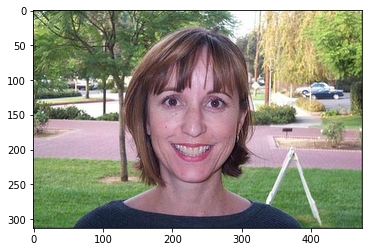

In [59]:
random_index = 70
distances, indices = neighbors.kneighbors([feature_list[random_index]])
plt.imshow(mpimg.imread(filenames[random_index]), interpolation='lanczos')

Looking for the most similar image from the dataset from  nearest neighbors

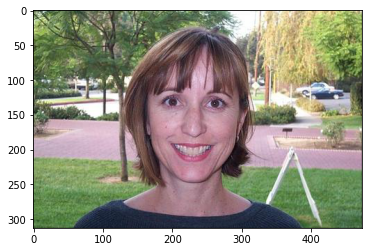

In [60]:
plt.imshow(mpimg.imread(filenames[indices[0][0]]))

Seems like that the first image is duplicate of the query image (as will be the case). So looking for the next nearest neighbor

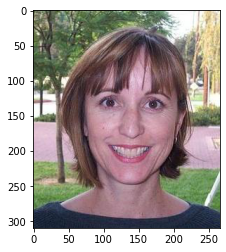

In [61]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]))

In [62]:
for i in range(5):
  print(distances[0][i])

5.1619136e-08
0.6090486
0.639893
0.6622637
0.6663854


In [63]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
        #plt.savefig('results/' + str(random.randint(0,10000))+'.pdf', format='pdf', dpi=1000)
        # We will use this line repeatedly in our code.

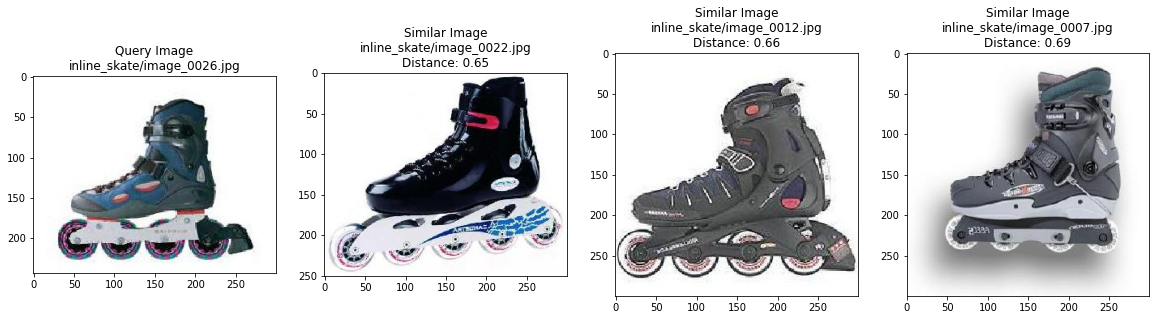

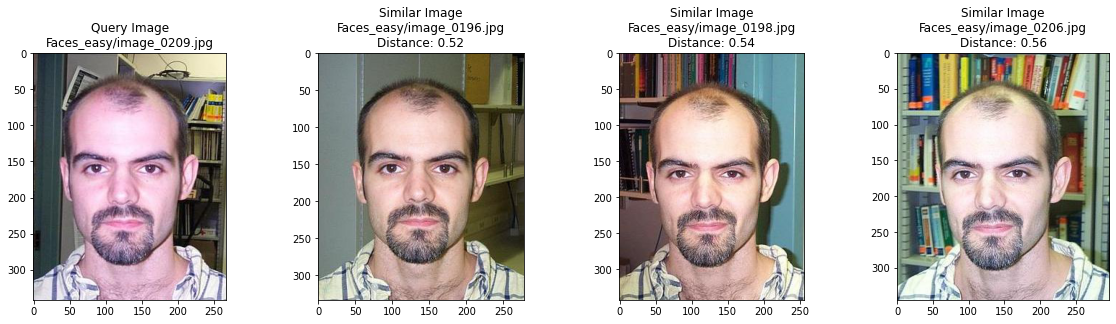

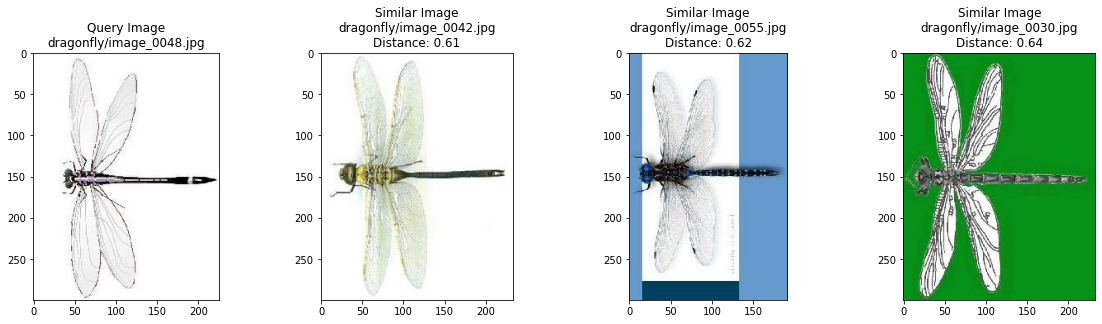

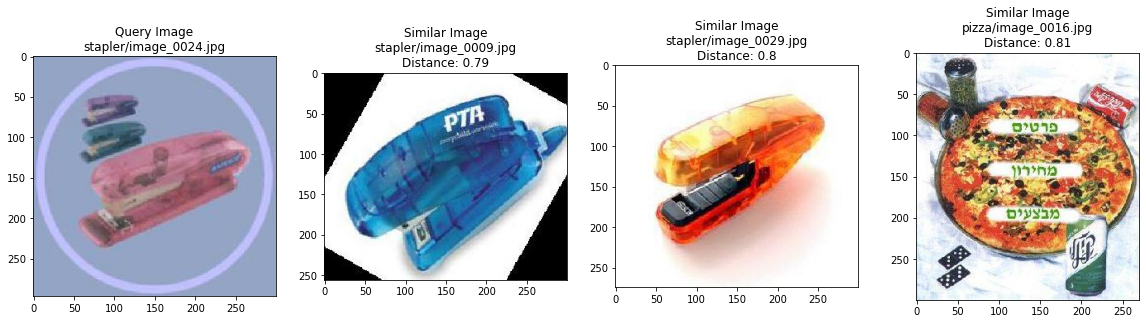

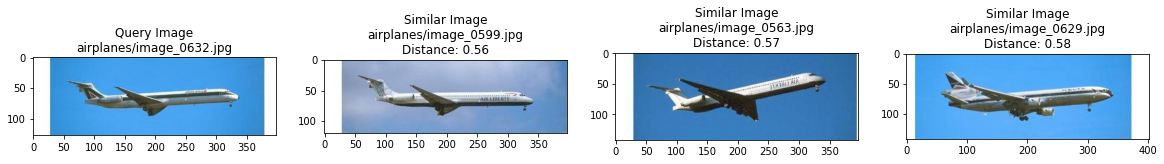

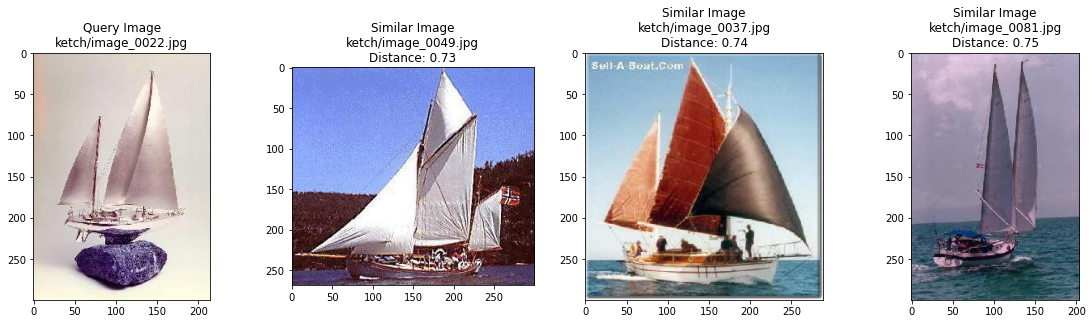

In [67]:
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

To get a sense of the similarity values we get, lets find the max, avg of the similiarity values

In [69]:
neighbors = NearestNeighbors(n_neighbors= len(feature_list), algorithm= 'brute', metric= 'euclidean').fit(feature_list)

distances, indices = neighbors.kneighbors(feature_list)

# Calculating the stats over the entire dataset

print("Median distance between all the photos:", np.median(distances))
print("Max distance between all the photos: ", np.max(distances))
print("Median distance between the most similar photos: ", np.median(distances[:, 2]))

Median distance between all the photos: 1.0041636
Max distance between all the photos:  1.2522099
Median distance between the most similar photos:  0.65938926


Select the amount of data you want to run the experiments on. Here we are selecting the entire dataset. To enable quicker run times you may want to select a portion of the dataset to experiment on.

In [ ]:
# Do not run this cell 
# this cell  is only provided as a reference

selected_features = feature_list[:]
selected_class = class_ids[:]
selected_filenames = filenames[:]

# Performing PCA for reducing the dimensionality before feeding to T-SNE

In [71]:
num_feature_dimensions = 100
pca = PCA(n_components = num_feature_dimensions)
feature_list_compressed = pca.fit_transform(feature_list)


Selecting the lst 4000 features

In [72]:
selected_features = feature_list_compressed[:4000]
selected_class = class_ids[:4000]
selected_filenames = filenames[:4000]


Using T-SNE to plot the features. after reducing the dimensions of the data

In [73]:
start_time = time.time()
tsne_results = TSNE(n_components = 2, verbose = 1, perplexity = 30, n_iter = 1000, metric = 'euclidean').fit_transform(selected_features)
print("Elapsed time for TSNE: ", time.time() - start_time)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.039s...
[t-SNE] Computed neighbors for 4000 samples in 2.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.143678
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.855247
[t-SNE] KL divergence after 1000 iterations: 1.093887
Elapsed time for TSNE:  24.05917477607727


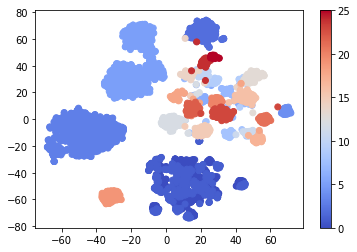

In [75]:
color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=selected_class,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()
# To save the plot in a high definition format i.e. PDF, uncomment the following line:
#plt.savefig('results/' + str(ADD_NAME_HERE)+'.pdf', format='pdf', dpi=1000)

In [76]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from PIL import Image


def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()

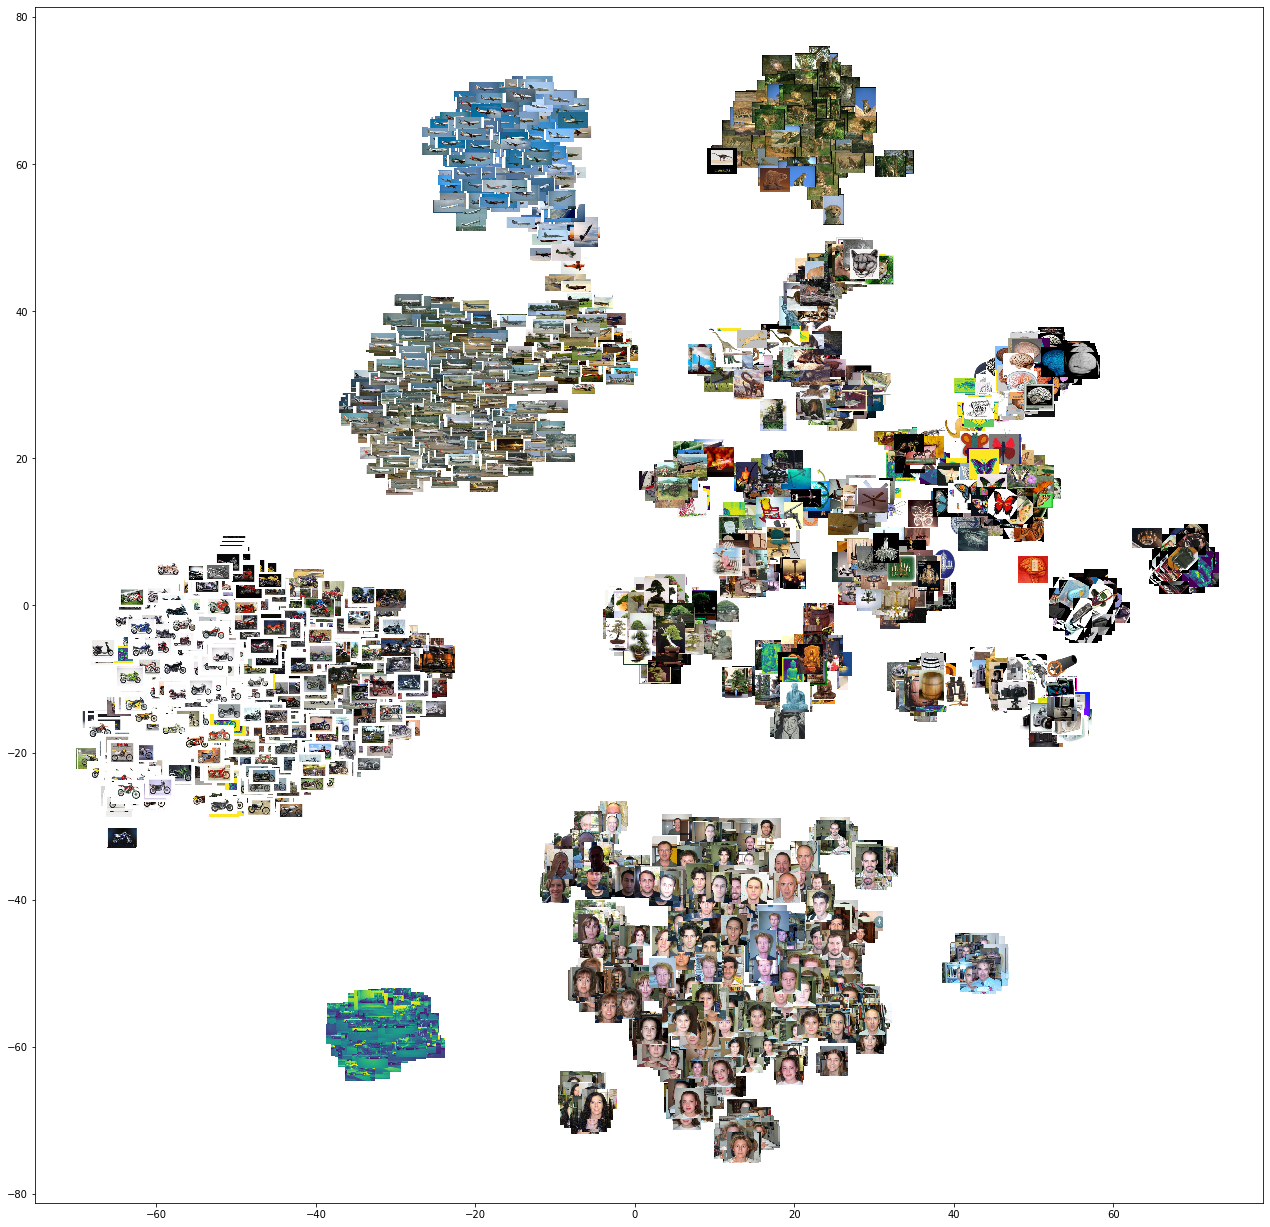

In [77]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

The `show_tsne` function piles images one on top of each other, making it harder to discern the patterns as the density of images is high. To help visualize the patterns better, we write another helper function `tsne_to_grid_plotter_manual` that spaces the images evenly.

In [78]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.show()

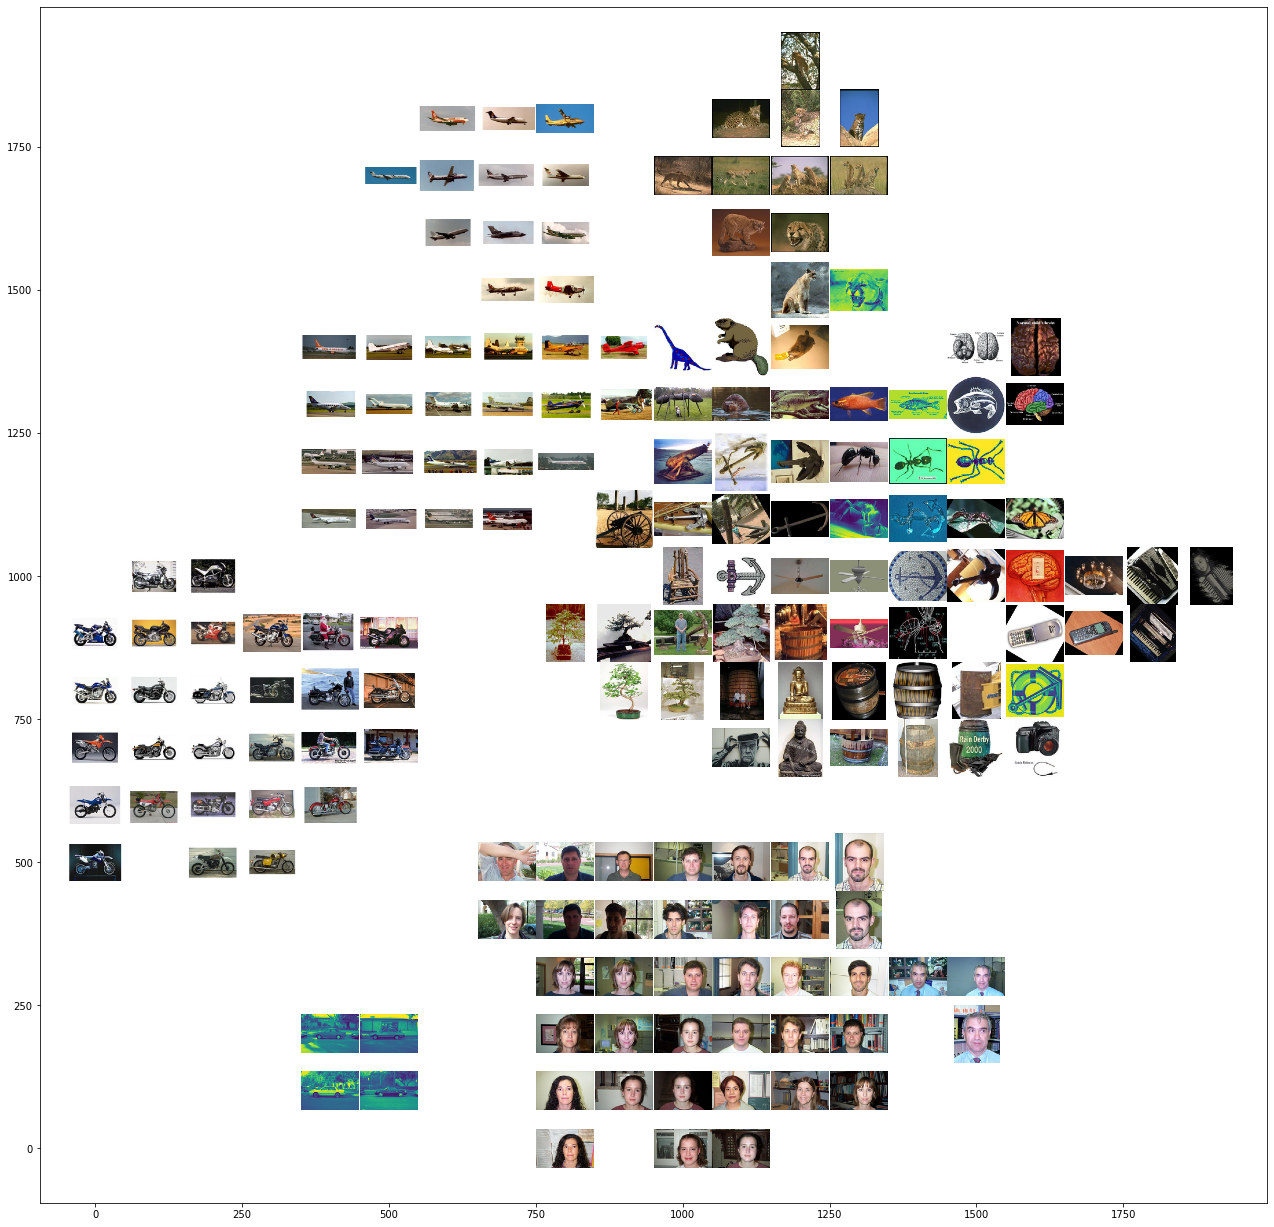

In [79]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)